In this notebook we are trying to forecast the Weighted price from the Bitcoin dataset. We will use ARIMA, Auto ARIMA and Long Short Term Memory(LSTM) networks methods to forecast the Bitcoin Price Data from January 2012 to August 2019(Kaggle Bitcoin DataSet).

The following articles/blogs were referred in making this notebook:
1.  https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
2.  https://machinelearningmastery.com/time-series-data-stationary-python/
3.  https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
4.  https://www.statisticshowto.datasciencecentral.com/unit-root/ 
5.  https://people.duke.edu/~rnau/411arim3.htm
6.  https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
7.  https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [1]:
import statsmodels
import pmdarima as pm

In [2]:
ls

ARIMA_project notes.pages*   Bitcoin_day4.ipynb
Bitcoin_ARIMA_ML.ipynb       bitcoin-historical-data/
Bitcoin_ARIMA_ML_copy.ipynb


In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



import os
for dirname, _, filenames in os.walk('bitcoin-historical-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

bitcoin-historical-data/month_data_ACF.png
bitcoin-historical-data/week_data_ACF.png
bitcoin-historical-data/Bitcoin_Day2.ipynb
bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv
bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv
bitcoin-historical-data/.ipynb_checkpoints/Bitcoin_Day2-checkpoint.ipynb


In [4]:
df_1 = pd.read_csv("bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv")

In [5]:
df_1

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3997692,1565567760,11555.57,11555.57,11540.37,11540.58,0.036868,425.909106,11552.336234
3997693,1565567820,11553.49,11556.22,11553.49,11556.22,0.623462,7204.428272,11555.520505
3997694,1565567880,11559.73,11561.22,11546.77,11561.22,0.159070,1838.731403,11559.252199
3997695,1565567940,11559.73,11589.73,11528.73,11528.73,16.198210,187504.635170,11575.638889


In [6]:
#Converting timestamp to datetime object
df_1.Timestamp = pd.to_datetime(df_1.Timestamp, unit='s')

# Resampling to daily frequency
df_1.index = df_1.Timestamp
df_1 = df_1.resample('D').mean()

# Resampling to weekly frequency
df_week_1 = df_1.resample('W').mean()

# Resampling to monthly frequency
df_month_1 = df_1.resample('M').mean()

In [7]:
#Dropping the NAN values from the dataset and using the weekly data 
df = df_week_1.Weighted_Price.dropna()

In [8]:
#Overview of the data
df

Timestamp
2012-01-01        4.639135
2012-01-08        5.990541
2012-01-15        6.843182
2012-01-22        6.433576
2012-01-29        5.946891
                  ...     
2019-07-21    10304.989689
2019-07-28     9889.752771
2019-08-04    10157.639145
2019-08-11    11674.654381
2019-08-18    11540.450291
Freq: W-SUN, Name: Weighted_Price, Length: 399, dtype: float64

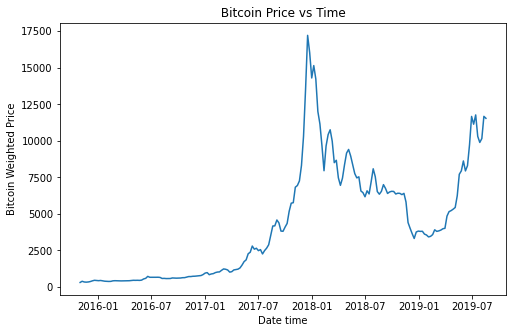

In [9]:
plt.figure(figsize=(8,5))
plt.plot(df[200:])
plt.xlabel("Date time")
plt.ylabel("Bitcoin Weighted Price")
plt.title(" Bitcoin Price vs Time ")
plt.show()

In [10]:
# Create Training and Test set 
train = df[200:349]   # we are not taking into account the initial data before 2016-01  
test = df[349:]

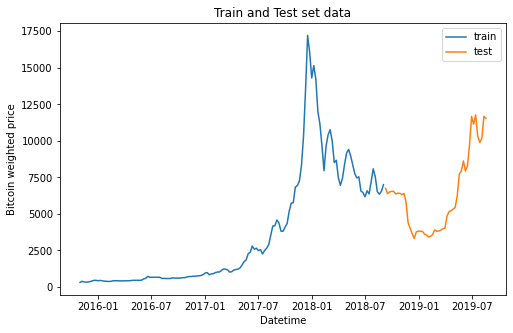

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.legend()
plt.title("Train and Test set data")
plt.xlabel("Datetime")
plt.ylabel("Bitcoin weighted price")
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
#Performing the Augemented Dickey Fuller test on our data to check for stationarity in the data
print("Dickey–Fuller test: p=%f" % adfuller(train)[1])
print('Dickey-Fuller test ADF Statistic: %f' % adfuller(train)[0])

Dickey–Fuller test: p=0.676423
Dickey-Fuller test ADF Statistic: -1.193412


Since the p value (p=0.676423) is greater the 0.05 so we can't reject the null hypothesis(The null hypothesis is that the time series is not stationary.) and can say the series is not stationary.
(The ADF statistic indicates whether we can strongly reject the null hypothesis or not. 

Our time series data is not stationary we will have to difference the series to make it stationary and determine the order of differencing that is required to make the series stationary. The order of differencing d, is inferred from the AutoCorrelation Function plots.

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

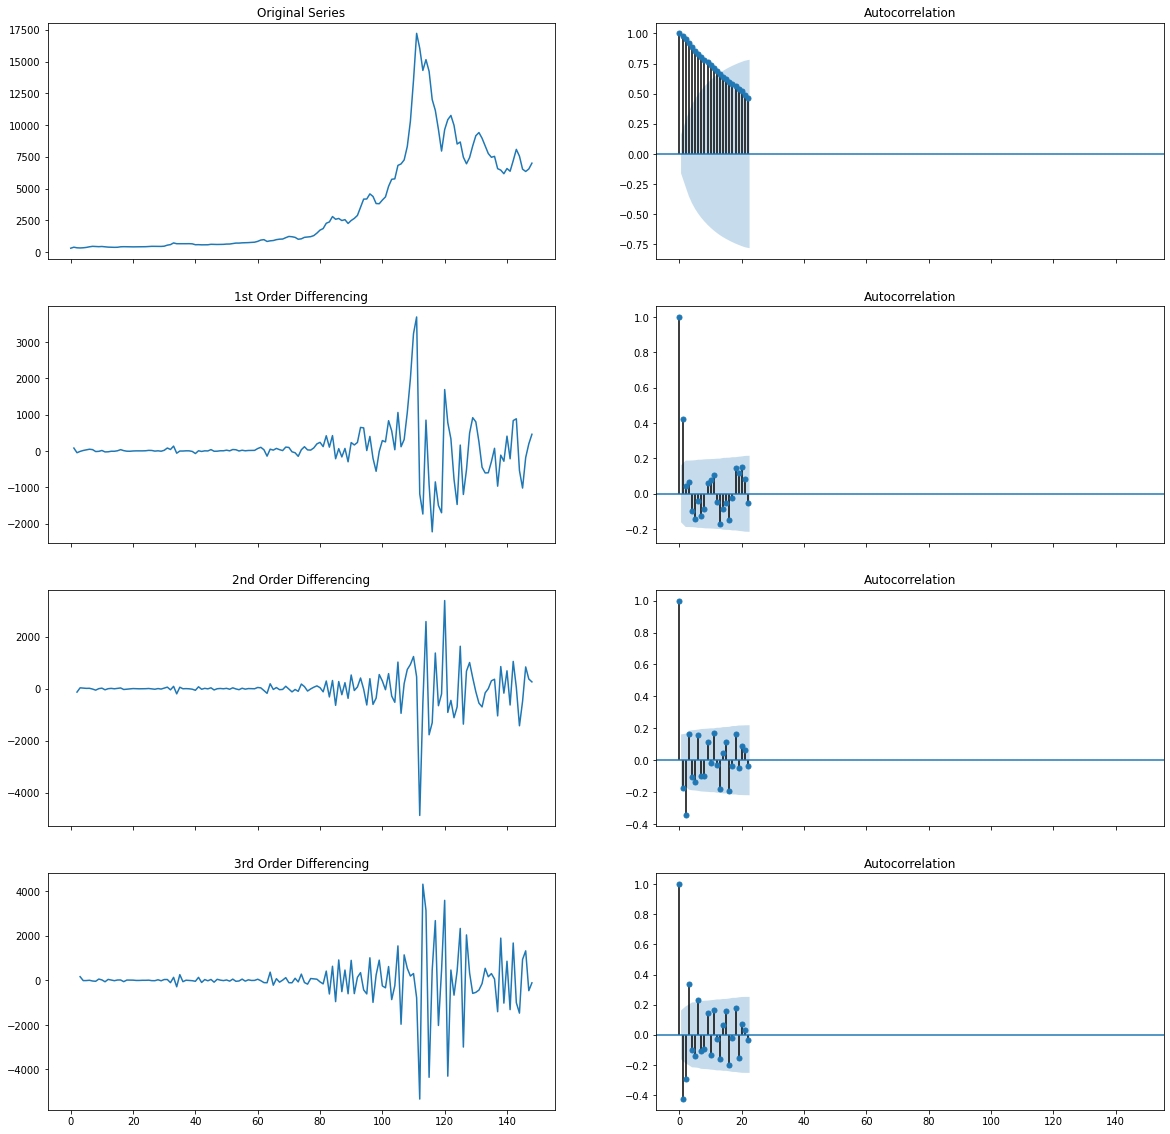

In [15]:
# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(20,20))
axes[0, 0].plot(train.values); axes[0, 0].set_title('Original Series')
plot_acf(train.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.diff().diff().dropna().values, ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(train.diff().diff().diff().values); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(train.diff().diff().diff().dropna().values, ax=axes[3, 1])


plt.show()

The AutoCorrelation Function for 2nd order differencing becomes negative very quickly hinting that the series might be over differenced. So we can set the order of differencing d to 1 even though the series may not look very stationary.

The next step is to determine p which is the order of Auto Regressive(AR) terms required and q which is the order of Moving Average(MA) terms required.

The order of the AR terms p can be determind by looking at the Partial AutoCorrelation Plot (PACF) of the 1st differenced series.

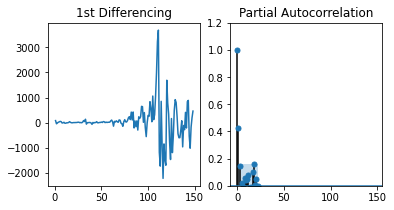

In [16]:
# PACF plot of 1st differenced series
#plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':240})

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(6,3))
axes[0].plot(train.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
#axes[1].set(xlim=(0,300))
plot_pacf(train.diff().dropna().values, ax=axes[1])

plt.show()

The first PACF lag is above the significance limit so we take p =1. This will also take care of the fact that the series might be slighlty under differenced.

Next we want to determine the order of q by looking at the ACF plot of the 1st differenced series. 

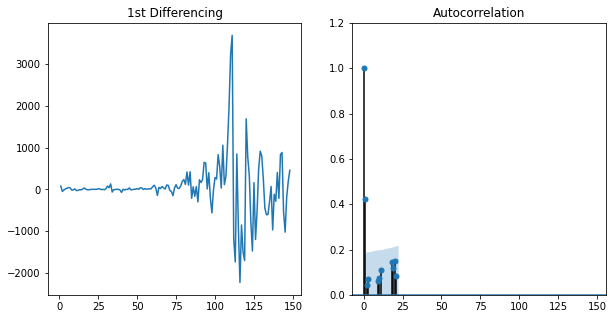

In [17]:
# ACF plot of 1st differenced series


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
axes[0].plot(train.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
#axes[1].set(xlim=(0,300))
plot_acf(train.diff().dropna().values, ax=axes[1])

plt.show()

The first two lags lie above the significance level. Since our series might be slightly under differenced so we set the value of q=1.

So our parameters for the ARIMA model are (1,1,1). We will now implement this model with the ARIMA package in statsmodels.

In [18]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  148
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1152.483
Method:                       css-mle   S.D. of innovations            582.188
Date:                Wed, 01 Apr 2020   AIC                           2312.967
Time:                        22:50:46   BIC                           2324.956
Sample:                             1   HQIC                          2317.838
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.8629     72.553      0.646      0.518     -95.339     189.064
ar.L1.D.y     -0.0569      0.142     -0.399      0.690      -0.336       0.222
ma.L1.D.y      0.6058      0.113      5.343      0.0

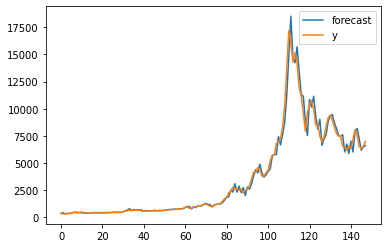

In [19]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

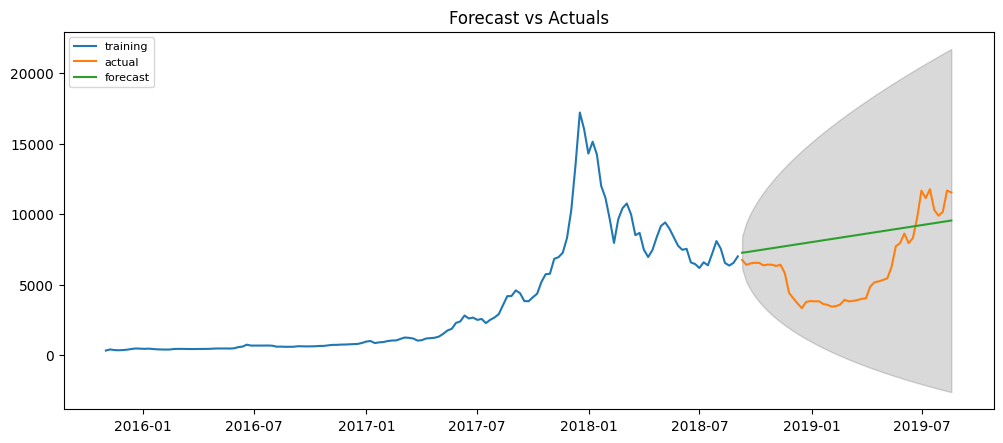

In [20]:
# Forecast
fc, se, conf = model_fit.forecast(50, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Now we will do the modeling of the time series data with Auto ARIMA

# Auto ARIMA

In [21]:
model_auto = pm.auto_arima(train,start_p=1, start_q=1,
                      test='adf',# use to determine the d 
                      max_p=3, max_q=3,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2312.921, BIC=2324.910, Time=0.161 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2348.022, BIC=2354.016, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2320.874, BIC=2329.865, Time=0.021 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2311.064, BIC=2320.055, Time=0.078 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2346.706, BIC=2349.703, Time=0.009 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2312.945, BIC=2324.934, Time=0.093 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2314.829, BIC=2329.815, Time=0.277 seconds
Total fit time: 0.692 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1152.532
Dat

The orders of the model are p=0,d=1,q=1

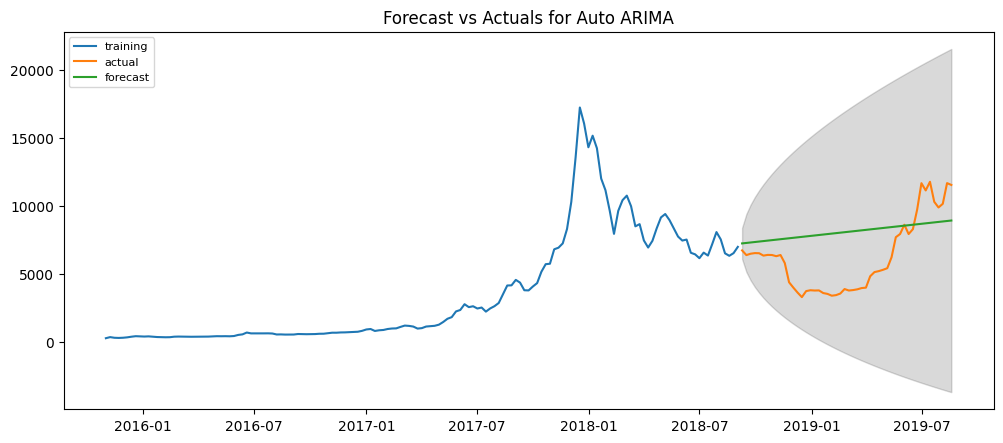

In [22]:
fc, conf = model_auto.predict(n_periods=50, return_conf_int=True, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series    = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals for Auto ARIMA')
plt.legend(loc='upper left', fontsize=8)
plt.show()


Now we will look for seasonality in the data series. 

In [23]:
from scipy.signal import find_peaks

In [24]:
#Finding peaks in the time series data
peaks, _ = find_peaks(train, height=0,distance=3)

In [25]:
peaks

array([  1,   7,  10,  17,  28,  33,  38,  41,  45,  53,  62,  70,  84,
        88,  96, 111, 114, 122, 125, 131, 136, 140, 143])

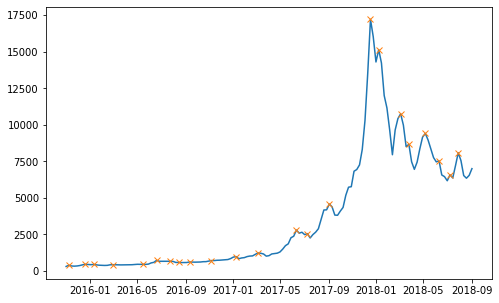

In [26]:
plt.figure(figsize=(8,5))
plt.plot(train)
plt.plot(train[peaks], "x")
plt.show()

In [27]:
#ignoring the first 10 peaks
peak=peaks[10:]
print(np.diff(peak).mean())

6.75


So lets take the seasonality to be 6. 

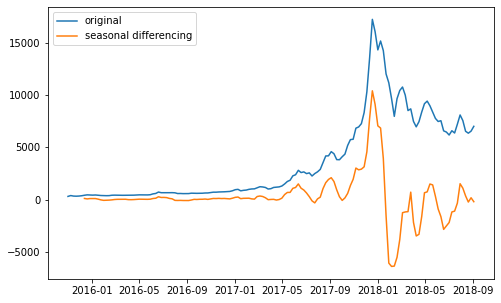

In [28]:
plt.figure(figsize=(8,5))
plt.plot(train,label='original')
plt.plot(train.diff(6),label='seasonal differencing')
plt.legend(loc='best', fontsize=10)
plt.show()

Now we will decompose the series into the seasonality, trend and residues using the seasonal_decompose package from statsmodels. The methods used for the decomposition will be additive and multiplicative.

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

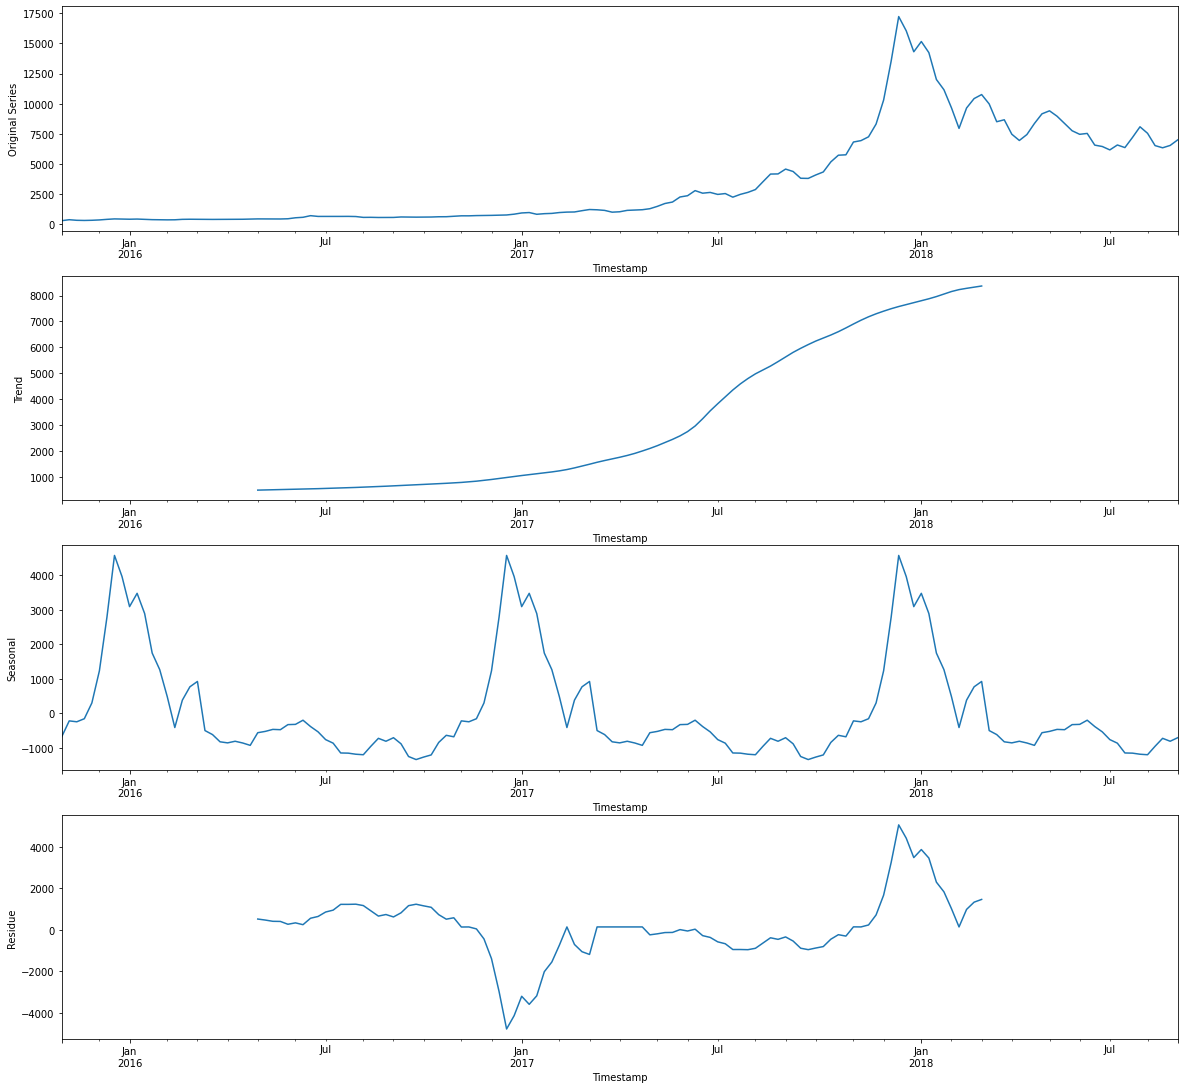

In [30]:
result = seasonal_decompose(train, model='additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
#plt.title("Seasonal Decomposition")
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')

plt.show()

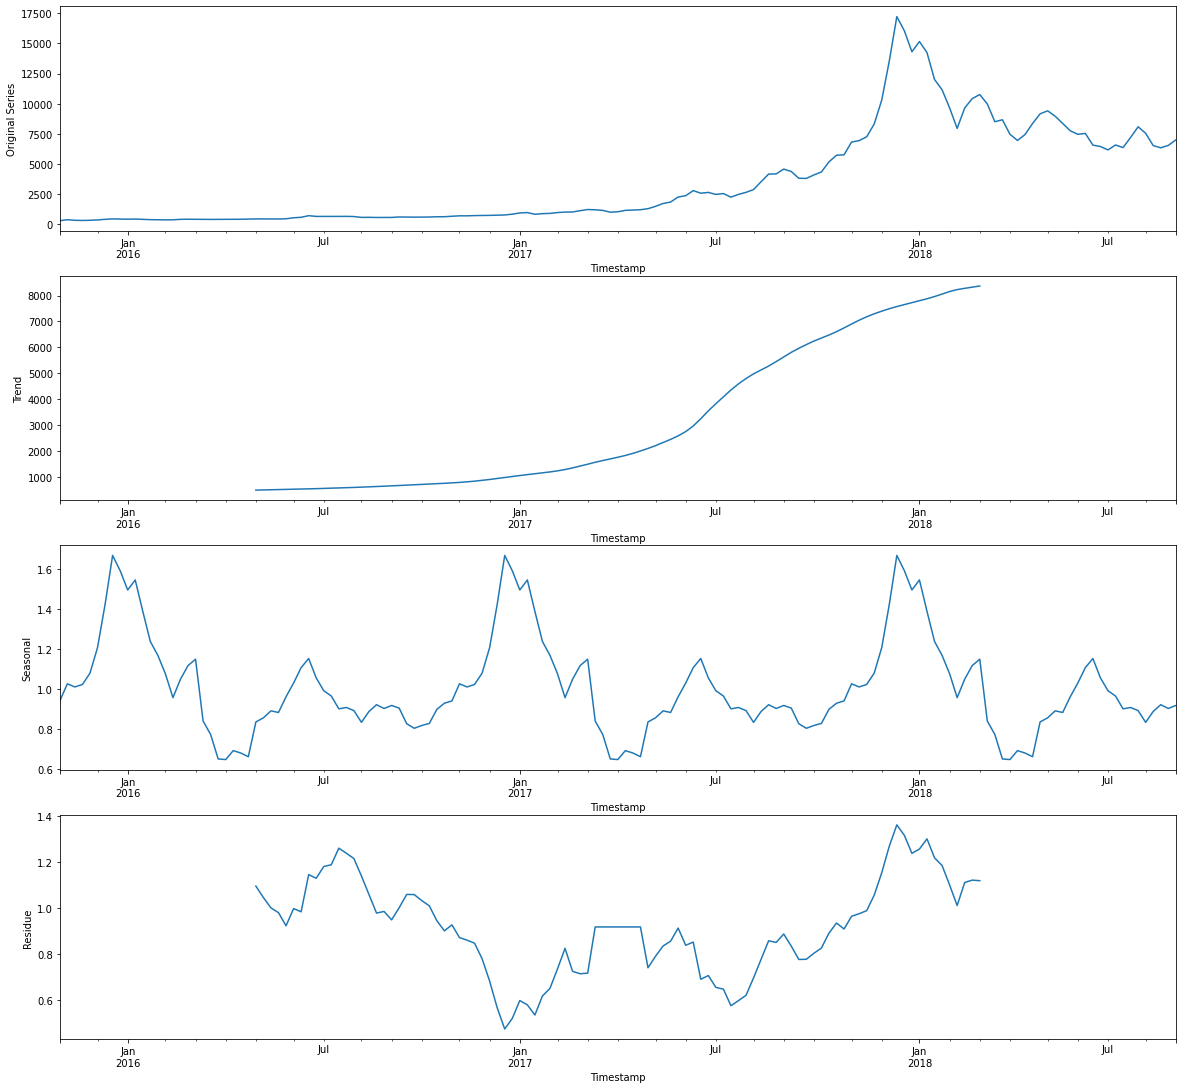

In [31]:
result_mu = seasonal_decompose(train, model='multiplicative')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
#plt.title("Seasonal Decomposition Multiplicative")
result_mu.observed.plot(ax=ax1).set_ylabel('Original Series')
result_mu.trend.plot(ax=ax2).set_ylabel('Trend')
result_mu.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result_mu.resid.plot(ax=ax4).set_ylabel('Residue')

plt.show()

We can see from the seasonal decomposition plot that there is annual seasonality. 

Now we will use the Auto ARIMA model with seasonality

In [33]:
sarima_model = pm.auto_arima(train,start_p=2, start_q=2,
                      test='adf',# use to determine the d 
                      max_p=3, max_q=3,
                      m=6,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=2, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sarima_model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(2, 0, 1, 6) (constant=True); AIC=2316.733, BIC=2343.707, Time=0.916 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=True); AIC=2348.022, BIC=2354.016, Time=0.011 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 6) (constant=True); AIC=2321.895, BIC=2333.884, Time=0.046 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 6) (constant=True); AIC=2312.212, BIC=2324.201, Time=0.132 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=False); AIC=2346.706, BIC=2349.703, Time=0.010 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 6) (constant=True); AIC=2311.064, BIC=2320.055, Time=0.088 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 0, 6) (constant=True); AIC=2312.340, BIC=2324.329, Time=0.128 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 1, 6) (constant=True); AIC=2310.036, BIC=2325.022, Time=0.259 seconds
Fit ARIMA: (0, 1, 1)x(2, 0, 1, 6) (constant=True); AIC=2311.459, BIC=2329.442, Time=0.354 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 2, 6) (constant=True); AIC=2311.594, BIC=2329.

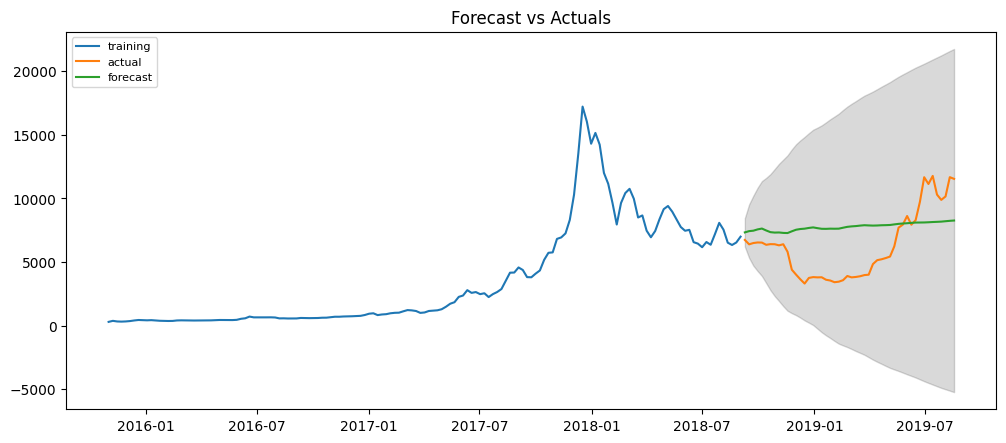

In [34]:
# Forecast
fc, conf = sarima_model.predict(n_periods=50, return_conf_int=True, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series    = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Machine Learning Approach

Now we will extend the approch to using Long Short Term Memory (LSTMs) networks. LSTM networks are useful because they can take into account the dependence on lags, they don't have long term dependency problems. (LSTM are a type of Recurrent Neural Networks(RNNs). RNN's are Neural Networks where the network uses some of the previous input values to make the predictions. LSTM's are capable of learning long term depedencies than RNNs.   


In [35]:
#Transformations on data and pre processing for LSTM RNNs


In [36]:
# Sliding Window Transformation
f=4 #Size of input layer 
x= np.zeros((len(df)-f,f))
for i in range(len(df)-f):
    x[i,:]=df[i:i+f]
y=df[f:]

In [37]:
#Normalisation
x/=df.max()

y/=df.max()

In [38]:
#Split into train and test set
n=(350 -f) 

x_train= x[200:n,:]
x_test = x[n:,:]

y_train= y[200:n]
y_test = y[n:]

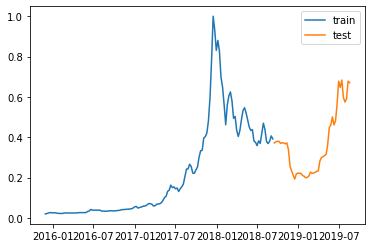

In [39]:
plt.plot(y_train,label='train')
plt.plot(y_test,label='test')
plt.legend()
plt.show()

In [40]:
import keras

Using TensorFlow backend.


In [41]:
n_features=1 # because a univariate time series analysis
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# define model
model_ml = Sequential()
model_ml.add(LSTM(100, activation='relu', input_shape=(f,n_features)))
model_ml.add(Dense(1))
model_ml.compile(optimizer='adam', loss='mse')

## A bit  about  the model

The Sequential model is a linear stack of layers. There is one input layer, 100 LSTM units in the hidden layer and an output layer. The input_shape tells the model the expected shape of input.

Using the Rectified Linear Unit "relu" activation function. Relu= max(0,z). Activation functions are attached to neurons of NNs which determine whether the neurons are activated or not.  

Model fitting through "adam" ("adaptive moment estimation", part of stochastic gradient descent, optimising algorith for gradient descent). 

Optimisation through the mean square error(mse) loss function. The mean squared error 'mse' is used as the loss function because its well suited for a regression type of problem. 

In [43]:
# fit model
model_ml.fit(x_train, y_train, epochs=len(y_train), verbose=0)

Prediction using x_test

In [44]:
yhat2 = model_ml.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], n_features)), verbose=0)

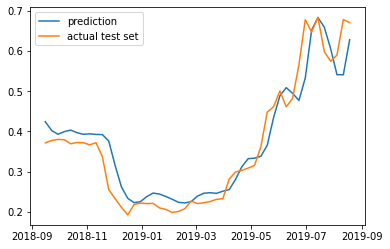

In [45]:
yhat3= pd.Series(list(yhat2), index=y_test.index)
plt.plot(yhat3,label='prediction')
plt.plot(y_test,label='actual test set')

plt.legend()
plt.show()

Now we will try to do some long term forecasting with this model so as to compare with the SARIMA models

In [46]:
# demonstrate prediction
yhat = model_ml.predict(x_train[-1].reshape(1,f,1), verbose=0)
x_new = x_train[-1,:]
yhat_list = [yhat]
for i in range(y_test.size):
    _l = list(x_new[(1-f):])
    _l.append(yhat)
    x_new = np.array(_l)
    yhat = model_ml.predict(x_new.reshape((1,f,1)), verbose=0)
    yhat_list.append(float(yhat))

In [47]:
float(yhat)

0.5058130621910095

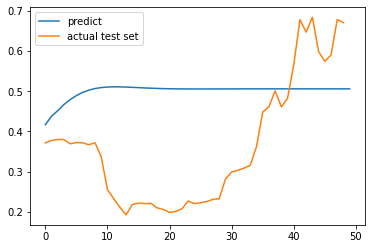

In [48]:
plt.plot(yhat_list,label='predict')
plt.plot(y_test.values,label='actual test set')
#plt.plot(y_train,label='train_data')
#plt.plot(df2,label='complete')
plt.legend()
plt.show()

Comparing the output from the LSTM model to Seasonal Auto Arima

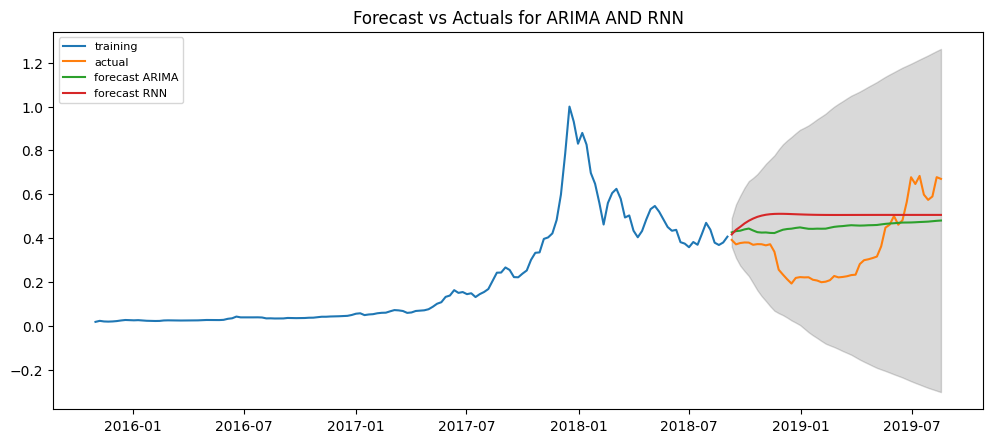

In [49]:
# Plot

fc_ml_series    = pd.Series(yhat_list, index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train/df.max(), label='training')
plt.plot(test/df.max(), label='actual')
plt.plot(fc_series/df.max(), label='forecast ARIMA')
plt.plot(fc_ml_series, label='forecast RNN')
plt.fill_between(lower_series.index, lower_series/df.max(), upper_series/df.max(), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals for ARIMA AND RNN')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [50]:
#Looking at the loss for the train set and test set
train_mse = model_ml.evaluate(x_train.reshape((x_train.shape[0], x_train.shape[1], n_features)),y_train, verbose=0)
test_mse = model_ml.evaluate(x_test.reshape((x_test.shape[0], x_test.shape[1], n_features)),y_test, verbose=0)

In [51]:
print(train_mse, test_mse)

0.0018249360704156634 0.0022867283194648977


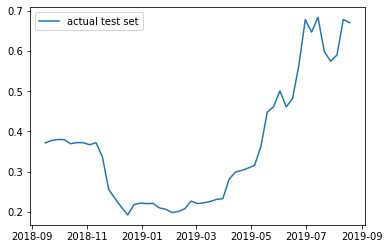

In [52]:
plt.plot(y_test,label='actual test set')
#plt.plot(y_train,label='train_data')
#plt.plot(df2,label='complete')
plt.legend()
plt.show()

In [53]:
y_test.values

array([0.37158295, 0.3775298 , 0.3801053 , 0.37950598, 0.36941591,
       0.37246293, 0.37197812, 0.36698193, 0.37193199, 0.33759301,
       0.25591298, 0.2332369 , 0.21191031, 0.19265193, 0.21836682,
       0.22200276, 0.22080775, 0.22126703, 0.21007671, 0.20645156,
       0.19875629, 0.2011836 , 0.20797005, 0.22708111, 0.22083258,
       0.22275513, 0.2259474 , 0.23128758, 0.23305641, 0.28156608,
       0.29928788, 0.30333849, 0.30900651, 0.31575236, 0.36227023,
       0.4477727 , 0.46136701, 0.50076712, 0.46117314, 0.4820155 ,
       0.56551235, 0.67771937, 0.64681872, 0.6837164 , 0.59846728,
       0.5743522 , 0.58990983, 0.67801122, 0.67021726])

In [54]:
y_test.index

DatetimeIndex(['2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07',
               '2018-10-14', '2018-10-21', '2018-10-28', '2018-11-04',
               '2018-11-11', '2018-11-18', '2018-11-25', '2018-12-02',
               '2018-12-09', '2018-12-16', '2018-12-23', '2018-12-30',
               '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24',
               '2019-03-31', '2019-04-07', '2019-04-14', '2019-04-21',
               '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
               '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16',
               '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
               '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
               '2019-08-18'],
              dtype='datetime64[ns]', name='Timestamp', freq='W-SUN')

 '2018-11-25'.. Checked the news on this day. "The price drop is likely the result of a series of forks this year, which produced parallel currencies like Bitcoin Cash. A planned fork of Bitcoin Cash took place on November 15th, and was accompanied by considerable angst from traders ahead of time. CoinDesk notes that Bitcoin Cash and several other bitcoin forks have reported losses of more than 10 percent in a 24 hour period." https://www.theverge.com/2018/11/25/18111261/bitcoin-crash-lost-40-percent-of-value-november-2018-cryptocurrency